## Object-Oriented Neural Networks in PyTorch (binary qwerties classification MLP)

In [25]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

### Generamos los datos para la clasificación binaria

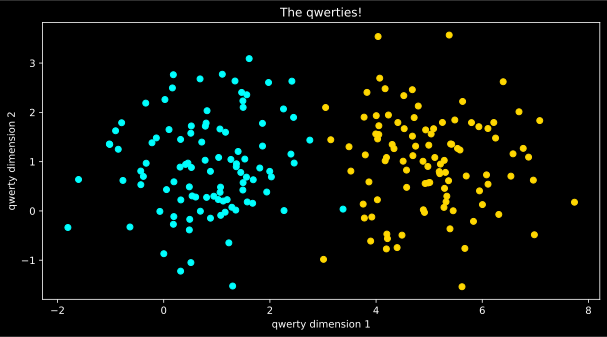

In [21]:
n_per_clust = 100 #número de datos que habrán alrededor de cada centro de categoría
blur = 1 #std, indica cómo de "dispersos" estarán los datos

#coordenadas de la nube de datos de cada categoría (solo eje x)
A = [  1, 1 ] #el centro de la categoría A (x=1,y=1)
B = [  5, 1 ] #el centro de la categoría B (x=5,y=1)

# generar datos aleatorios o "ruido" alrededor de cada centro (A,B)
a = [ A[0]+np.random.randn(n_per_clust)*blur , A[1]+np.random.randn(n_per_clust)*blur ]
b = [ B[0]+np.random.randn(n_per_clust)*blur , B[1]+np.random.randn(n_per_clust)*blur ]

# true labels
#para las etiquetas, asignamos ceros a la categoría A, y 1 a la categoría B
labels_np = np.vstack((np.zeros((n_per_clust,1)),np.ones((n_per_clust,1))))

# concatenamos los datos aleatorios en una matriz traspuesta
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(10,5))
plt.scatter(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],color="cyan")
plt.scatter(data[np.where(labels==1)[0], 0], data[np.where(labels==1)[0], 1], color="gold")

plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [23]:
# inspect types
print(type(data_np))
print(np.shape(data_np))
print(' ')

print(type(data))
print(np.shape(data))

<class 'numpy.ndarray'>
(200, 2)
 
<class 'torch.Tensor'>
torch.Size([200, 2])


## Creación del modelo usando clases

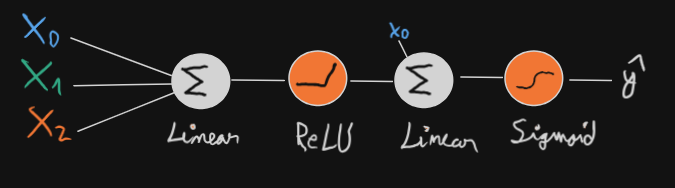

In [22]:
# model = nn.Sequential(

#         nn.Linear(2,1), 
#         nn.ReLU(),
#         nn.Linear(1,1),
#         nn.Sigmoid()
# )

### Esta clase hereda al módulo de herramientas de PyTorch `nn.Module`

In [36]:
class Model(nn.Module): 
    
    
    def __init__(self):
        super().__init__() #inincializamos las propiedades de la clase padre
        
        #atributos (capas del modelo)
        
        self.input = nn.Linear(2,1) #capa de entrada
        self.output = nn.Linear(1,1) #capa de salida
        
        
    def forward(self, x): #método de la clase del modelo, que toma las propiedades y atributos (capas) y las entradas
        
        x = self.input(x) #aplicamos suma lineal ponderada de la primera capa que toma las entradas reales
        x = F.relu(x) #función no-lineal
        
        x = self.output(x) #aplicamos la suma lineal ponderada de la salida del nodo anterior
        x = F.sigmoid(x) #aplicamos la función no-lineal sigmoide, que será la salida probabiística del modelo        
        
        return x

In [37]:
model = Model() #instanciamos la clase del modelo

In [38]:
#training

n_epochs = 1000
losses = torch.zeros(n_epochs)

loss_func = nn.BCELoss()

learning_rate = 0.1

optim = torch.optim.SGD(params=model.parameters(),
                       lr=learning_rate)

for epoch in tqdm(range(n_epochs)):
    
    #forward pass
    y_hat = model(data)
    
    #compute error
    loss = loss_func(y_hat, labels)
    losses[epoch] = loss
    
    #backward pass
    optim.zero_grad() #clear previous gradients cache
    loss.backward() #compute gradients
    optim.step() #update parameters
    
#     if epoch % 25 == 0:
#         print(f"Epoch no. {epoch} completed")
    

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1400.73it/s]


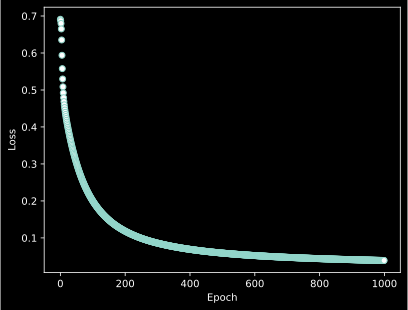

In [39]:
plt.plot(losses.detach(),'o',markerfacecolor='w',linewidth=.1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [40]:
predictions = model(data) #obtenemos los outputs del modelo, que estarán en probabilidades de 0 y 1 por la función sigmoide

pred_labels = predictions > 0.5 #hacemos una "máscara" del output, para preguntar por aquellos con una probabilidad > 0.5 (pertenecerán a la categoría 1, "A")

In [41]:
pred_labels[:5]

tensor([[False],
        [False],
        [False],
        [ True],
        [False]])

In [42]:
# find errors
misclassified = np.where(pred_labels != labels)[0] #índices del set de datos de valores clasificados incorrectamente por el modelo

In [43]:

# total accuracy
total_acc = 100-100*len(misclassified)/(2*n_per_clust) #precisión: nº no acertados entre / numero total observaciones, menos 100

print(f'Final accuracy: {total_acc}')

Final accuracy: 99.5


In [44]:
pred_labels.shape

torch.Size([200, 1])

In [45]:
data.shape

torch.Size([200, 2])

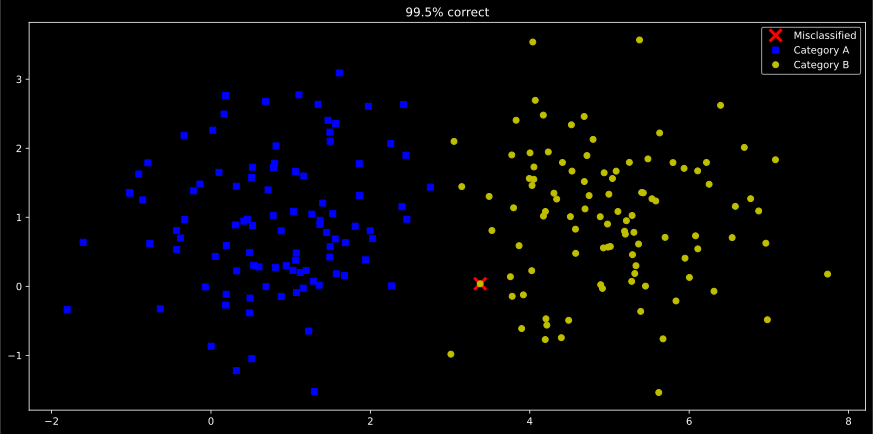

In [46]:
# plot the labeled data
fig = plt.figure(figsize=(15,7))

#generamos "X" para la categoria A,B, indexando en los índices donde el modelo no acertó
plt.plot(data[misclassified,0] ,data[misclassified,1],'rx',markersize=12,markeredgewidth=3)


#usando el operador "~" invertimos los resultados (si indexamos por los pred_labels, obtenemos los puntos con probabilidad > 0.5, categoria B)
#pero como deseamos trazar los de la categoria A, buscamos las que no son 0.5
plt.plot(data[np.where(~pred_labels)[0],0],data[np.where(~pred_labels)[0],1],'bs') #trazamos los puntos indexados para las predicciones de la categoria A

plt.plot(data[np.where(pred_labels)[0],0] ,data[np.where(pred_labels)[0],1], 'yo') #y por último, trazamos los de la categoría B (usando [filas, col])

plt.legend(['Misclassified','Category A','Category B'],bbox_to_anchor=(1,1))
plt.title(f'{total_acc}% correct')
plt.show()

### Para trazar el `decision boundary` o el límite de decisión para las categorías a clasificar por el modelo, usaremos esta otra técnica

In [47]:
#usando meshgrid() creamos una cuadrícula rectangular a partir de una matriz de valores x y otra y
#- cada píxel representa una celda de la cuadrícula en el espacio de características 2D

#para cada celda de la cuadrícula, se asignará un color correspondiente a la predicción del modelo
#-después esa imagen servirá como fondo para un scatterplot con los puntos coloreados por su categoría real

c indica el color, el vector labels indica el color para cada uno de los 200 puntos, azul para labels=0 y rojo para labels=1

In [48]:
#Encontrar los mínimos y máximos de nuestros datos
x_min, x_max = data[:, 0].min() - 0.1, data[:,0].max() + 0.1
y_min, y_max = data[:, 1].min() - 0.1, data[:, 1].max() + 0.1

In [49]:
#usando esos límites, creamos la cuadrícula
xx, yy = np.meshgrid(np.linspace(x_min,x_max, 100), np.linspace(y_min, y_max, 100))
#creamos 100 puntos equidistantes en coordenadas de x e y

In [50]:
#ahora obtendremos las predicciones para cada coordenadada de la cuadrícula
x_in = np.c_[xx.ravel(), yy.ravel()] #concatenamos xx e yy (ambas en dimensión 1D) a través de la segunda dimensión (axis=1)

In [51]:
x_in = torch.tensor([x_in]).float() #convertimos a tensor

C:\Users\pablo\AppData\Local\Temp\ipykernel_3816\2135787221.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  x_in = torch.tensor([x_in]).float() #convertimos a tensor


In [52]:
y_pred = model(x_in)

In [53]:
y_pred = np.round(y_pred.detach()).reshape(xx.shape) #redondeamos para categorizar probabilidades > 0.5 a ser 1 y viceversa, y damos la forma correcta

In [54]:
y_pred

tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

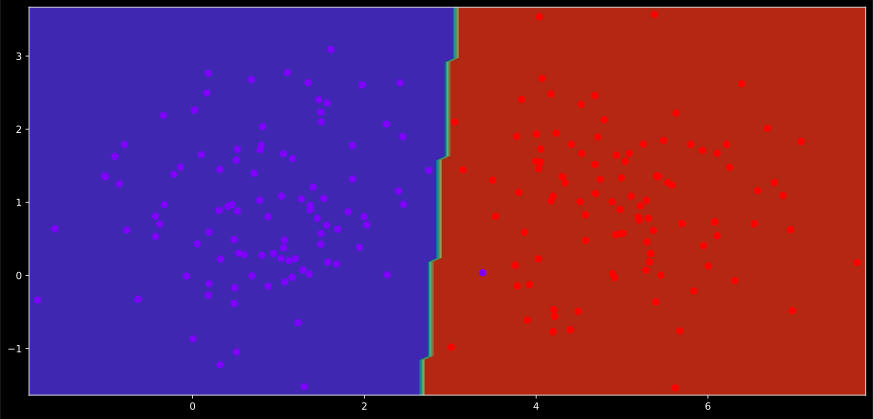

In [55]:
#graficamos
plt.figure(figsize=(15,7));
plt.contourf(xx, yy, y_pred, cmap="rainbow", alpha=0.7 ); #rainbow / cmap=plt.cm.binary_r
plt.scatter(data[:,0], data[:, 1], c=labels, s=40, cmap="rainbow"); #rainbow / cmap="Paired"
plt.xlim(xx.min(), xx.max());
plt.ylim(yy.min(), yy.max());
# plt.colorbar(shrink=0.5)